この notebook では、最大の時間発展 $t_K$ と、各時間 $t$ における適切な $n_{\text{step}}$ を求める。

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/root/workdir/fourier_learning_ibm")
pprint.pprint(sys.path)

%cd /root/workdir/fourier_learning_ibm

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/root/workdir/fourier_learning_ibm']
/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import numpy as np
from numpy.linalg import qr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import time
import networkx as nx
from heisenberg import (
    HeisenbergModel,
    HeisenbergModelGPU,
    get_graph,
    get_positions,
    fidelity_gpu,
)
from setup import setup_backend
from heisenberg import HeisenbergModel, get_graph, get_positions
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
    SparsePauliOp,
)
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QuantumVolume
import json
import math

In [4]:
import warnings

warnings.filterwarnings("ignore")

### Config backend 

In [5]:
# state vector simulator
# backend_qpu, backend_sv_noiseless, backend_sv_noisy = setup_backend(
#     qpu_name="ibm_marrakesh", device="GPU", method="statevector"
# )

Using backend QPU: <IBMBackend('ibm_marrakesh')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'measure', 'cz', 'id', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('sx', (0,)), ('sx', (1,)), ('sx', (2

In [6]:
# density matrix simulator
backend_qpu, backend_dm_noiseless, backend_dm_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="density_matrix"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'measure', 'cz', 'id', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('sx', (0,)), ('sx', (1,)), ('sx', (2

In [7]:
# MPS simulator
# backend_qpu, backend_mps_noiseless, backend_mps_noisy = setup_backend(
#     qpu_name="ibm_marrakesh", device="GPU", method="matrix_product_state"
# )

In [8]:
# Tensor network simulator
# backend_qpu, backend_tn_noiseless, backend_tn_noisy = setup_backend(
#     qpu_name="ibm_marrakesh", device="GPU", method="tensor_network"
# )

## ノイズありシミュレーション

ランダムに複数個作ったハミルトニアンについて、ノイズありの積公式シミュレーションを行う。その後、複数ハミルトニアンについての平均 fidelity が閾値 xx 以上となる最大の $t$ を $t_K$ とする。

おさらいになるが、私たちはハミルトニアン $H$ の関数 $f(H)$ を求めたい。そこで、$f$ を $[-C, C]$ で定義される周期 $2C$ の関数と見てフーリエ級数近似する:
\begin{aligned}
f(x) &\simeq a_0 + \sum_{k=1}^K \left(a_k \cos \frac{k \pi x}{C}+b_k \sin \frac{k \pi x}{C}\right) \\
\therefore \operatorname{Tr}[f(H)\rho]
&\simeq a_0 + \sum_{k=1}^K \left( a_k \operatorname{Re}\left[\operatorname{Tr}\left[e^{-i t_k H} \rho\right]\right] + b_k \operatorname{Im}\left[\operatorname{Tr}\left[e^{-i t_k H} \rho\right]\right] \right) \\
&\qquad \qquad \left(t_k = \frac{k\pi}{C} \right) \\
\end{aligned}

上の式より特徴量の個数は、実部・虚部合わせて $2K+1$ である。またあらゆる (1 次元ハイゼンベルグ) ハミルトニアン $H$ について $C\ge\|H\|$ としたいので、
\begin{aligned}
C=3 \; \left( = 3 \sum_{i=0}^{n-2} |J_i| \ge \|H\| \right) 
\end{aligned}
とする。

In [ ]:
# from koduck

n_qubits = 12
n_samples = 5
# C = 3 * (n_qubits - 1)
C = 3  # H が ||H|| <= 3 となるように正規化されているため
# C = 5

if n_qubits == 4:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 20.0
elif n_qubits == 8:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 20.0
else:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8]
    max_time = 20.0

# t_k = k * pi / C
times = np.arange(0, max_time, np.pi / C)
print(f"times: {times}\n")
results = []
rng = np.random.default_rng(42)

# 保存用のファイルを初期化
with open(f"results/get_nstep/temp_progress.txt", "w") as f:
    f.write("")  # ファイルを空にする

for i in range(n_samples):
    # 途中経過を表示 + ファイルに保存
    progress_report = f"sample: {i}"
    print(progress_report)
    with open(
        f"results/get_nstep/temp_progress.txt", "a"
    ) as f:  # 使い回すので temp をつける
        f.write(progress_report + "\n")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    # ハイゼンベルグモデルを生成
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModelGPU(n_qubits, G)

    for t in times:
        # initial state
        state_init = Statevector.from_label("0" * n_qubits)

        start = time.time()
        # Exact simulation (Non-Trotter)
        state_exact = heisenberg.exact_simulation(t, phase=0)
        end = time.time()
        elapsed_time = end - start
        print(f"Exact simulation elapsed_time: {elapsed_time:.3f}[s]")

        # Trotter simulation
        for n_step in n_steps:
            if n_step == 0:
                n_step = 1

            circuit = heisenberg.get_circuit(t, n_step, phase=0)
            circuit.remove_final_measurements()
            # exec_circuit = transpile(circuit, backend_sv_noisy)
            exec_circuit = transpile(circuit, backend_dm_noisy)
            exec_circuit.save_density_matrix()

            start = time.time()
            # result = backend_sv_noisy.run(exec_circuit).result()
            result = backend_dm_noisy.run(exec_circuit).result()
            state_trotter = result.data()["density_matrix"]

            # fidelity = state_fidelity(state_exact, state_trotter)
            fidelity = fidelity_gpu(state_exact, state_trotter)  # GPU で計算

            end = time.time()
            elapsed_time = end - start

            # 途中経過を表示 + ファイルに保存
            progress_report = f"t: {t:.3f}, n_step: {n_step}, fidelity: {fidelity:.3e}, elapsed_time: {elapsed_time:.3f}[s]\n"
            print(progress_report)
            with open(
                f"results/get_nstep/temp_progress.txt", "a"
            ) as f:  # 使い回すので temp をつける
                f.write(progress_report + "\n")

            results.append(
                {
                    "sample": i,
                    "t": t,
                    "n_step": n_step,
                    "fidelity": fidelity,
                }
            )

    print()

times: [ 0.          1.04719755  2.0943951   3.14159265  4.1887902   5.23598776
  6.28318531  7.33038286  8.37758041  9.42477796 10.47197551 11.51917306
 12.56637061 13.61356817 14.66076572 15.70796327 16.75516082 17.80235837
 18.84955592 19.89675347]

sample: 0


Exact simulation elapsed_time: 6.101[s]
t: 0.000, n_step: 1, fidelity: 1.000e+00, elapsed_time: 6.209[s]

t: 0.000, n_step: 2, fidelity: 1.000e+00, elapsed_time: 5.518[s]

t: 0.000, n_step: 3, fidelity: 1.000e+00, elapsed_time: 4.777[s]

t: 0.000, n_step: 4, fidelity: 1.000e+00, elapsed_time: 5.434[s]

t: 0.000, n_step: 5, fidelity: 1.000e+00, elapsed_time: 4.767[s]

t: 0.000, n_step: 6, fidelity: 1.000e+00, elapsed_time: 5.607[s]

t: 0.000, n_step: 7, fidelity: 1.000e+00, elapsed_time: 5.911[s]

t: 0.000, n_step: 8, fidelity: 1.000e+00, elapsed_time: 6.696[s]

Exact simulation elapsed_time: 3.564[s]
t: 1.047, n_step: 1, fidelity: 8.761e-01, elapsed_time: 5.324[s]

t: 1.047, n_step: 2, fidelity: 7.832e-01, elapsed_time: 6.004[s]

t: 1.047, n_step: 3, fidelity: 6.984e-01, elapsed_time: 5.517[s]

t: 1.047, n_step: 4, fidelity: 6.249e-01, elapsed_time: 6.521[s]

t: 1.047, n_step: 5, fidelity: 5.588e-01, elapsed_time: 6.832[s]

t: 1.047, n_step: 6, fidelity: 5.002e-01, elapsed_time: 6.528[

In [10]:
df = pd.DataFrame(results)
# t と sample と n_step ごとに sta_fidelity をグループ化
df_grouped = df.groupby(["t", "sample", "n_step"]).agg({"fidelity": "mean"})
df_grouped = df_grouped.reset_index()
display(df_grouped)

,t,sample,n_step,fidelity
0,0.000000,0,1,1.0
1,0.000000,0,2,1.0
2,0.000000,0,3,1.0
3,0.000000,0,4,1.0
4,0.000000,0,5,1.0
...,...,...,...,...
795,19.896753,4,4,0.343665
796,19.896753,4,5,0.442395
797,19.896753,4,6,0.440343
798,19.896753,4,7,0.406521


In [11]:
# fidelity の sample に対する平均と分散を計算
df_grouped_mean = df_grouped.groupby(["t", "n_step"]).agg({"fidelity": "mean"})
df_grouped_mean = df_grouped_mean.reset_index()
df_grouped_std = df_grouped.groupby(["t", "n_step"]).agg({"fidelity": "std"})
df_grouped_std = df_grouped_std.reset_index()

# json に保存
df_grouped_mean.to_json(
    f"results/get_nstep/{n_qubits}Q/fidelity_vs_time_rough.json",
    orient="records",
    indent=4,
)
df_grouped_std.to_json(
    f"results/get_nstep/{n_qubits}Q/fidelity_vs_time_rough_std.json",
    orient="records",
    indent=4,
)

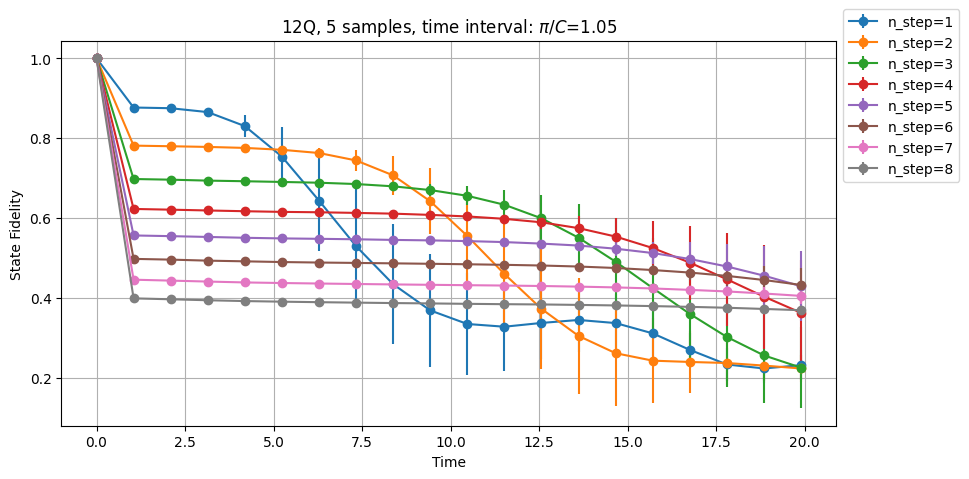

In [12]:
# Load json
df_grouped_mean = pd.read_json(
    f"results/get_nstep/{n_qubits}Q/fidelity_vs_time_rough.json"
)
df_grouped_std = pd.read_json(
    f"results/get_nstep/{n_qubits}Q/fidelity_vs_time_rough_std.json"
)

# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped_mean[df_grouped_mean["n_step"] == n_step]
    plt.errorbar(
        df_tmp["t"],
        df_tmp["fidelity"],
        yerr=df_grouped_std[df_grouped_std["n_step"] == n_step]["fidelity"],
        label=f"n_step={n_step}",
        marker="o",
    )
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
plt.grid()
plt.title(rf"{n_qubits}Q, {n_samples} samples, time interval: $\pi/C$={np.pi/C:.2f}")
plt.savefig(
    f"results/get_nstep/{n_qubits}Q/fidelity_vs_time_rough.pdf", bbox_inches="tight"
)
plt.show()

In [14]:
threshold = 0.60

# df_grouped_mean の sta_fidelity が、いずれの n_step でも threshold を超える最大の time を取得
max_time = df_grouped_mean[df_grouped_mean["fidelity"] > threshold]["t"].max()
print(f"max_time (t_K): {max_time:.2f}")

# max_time 以下の t のみに絞る
df_grouped_mean_reduced = df_grouped_mean[df_grouped_mean["t"] <= max_time]
df_grouped_std_reduced = df_grouped_std[df_grouped_std["t"] <= max_time]

# 絞った各 t において、sta_fidelity の平均が最大となる n_step を取得
df_max_n_step = df_grouped_mean_reduced.loc[
    df_grouped_mean_reduced.groupby("t")["fidelity"].idxmax(),
    ["t", "n_step", "fidelity"],
]
df_max_n_step.reset_index(drop=True, inplace=True)

print(
    f"number of time points: {len(df_max_n_step)}, so K = {len(df_max_n_step) - 1} (except for t=0)"
)
display(df_max_n_step)

# json に保存 (orient="records" で行ごとに保存)
df_max_n_step.to_json(
    f"results/get_nstep/{n_qubits}Q/threshold{threshold:.2f}/optimal_n_step.json",
    orient="records",
    indent=4,
)

max_time (t_K): 11.52
number of time points: 12, so K = 11 (except for t=0)


,t,n_step,fidelity
0,0.000000,1,1.000000
1,1.047198,1,0.876665
2,2.094395,1,0.874939
3,3.141593,1,0.865199
4,4.188790,1,0.830213
5,5.235988,2,0.770913
6,6.283185,2,0.762874
7,7.330383,2,0.744273
8,8.377580,2,0.706917
9,9.424778,3,0.670175


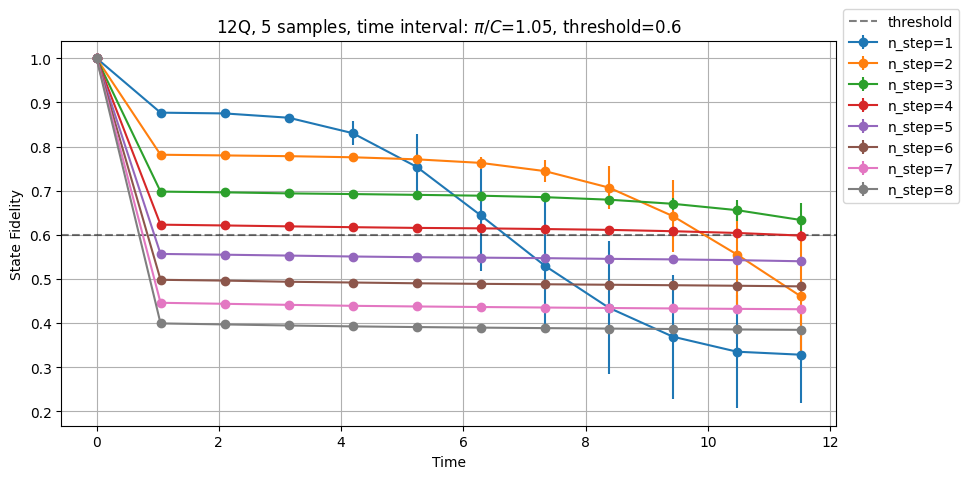

In [15]:
# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped_mean_reduced["n_step"].unique():
    df_tmp = df_grouped_mean_reduced[df_grouped_mean_reduced["n_step"] == n_step]
    plt.errorbar(
        df_tmp["t"],
        df_tmp["fidelity"],
        yerr=df_grouped_std_reduced[df_grouped_std_reduced["n_step"] == n_step][
            "fidelity"
        ],
        label=f"n_step={n_step}",
        marker="o",
    )
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.axhline(
    y=threshold, linestyle="dashed", label="threshold", color="black", alpha=0.5
)
plt.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
plt.grid()
plt.title(
    rf"{n_qubits}Q, {n_samples} samples, time interval: $\pi/C$={np.pi/C:.2f}, threshold={threshold}"
)
plt.savefig(
    f"results/get_nstep/{n_qubits}Q/threshold{threshold:.2f}/fidelity_vs_time_detail.pdf",
    bbox_inches="tight",
)
plt.show()